In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the names in the dataset
words = open('names.txt',  'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
#building the vocabulary of characters and mapping them to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [163]:
#build datasets

block_size = 3 # context length
vocab_size = 27 # number of chars in our char vocabulary (total possible outputs)

def build_dataset(words):
    #dataset prep
    X, Y = [], []  
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [164]:
g = torch.Generator().manual_seed(2147483647) #for reproducibility

n_embed = 10 # dimensions of the embedding vectors corresponding to each of the character
n_hidden = 200 # number of neurons in the hidden tanh layer

#initialisation
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3) / ((block_size * n_embed)**2) #gain/sqroot(inputs) (kaiming init)    # 0.2 #very very low to avoid hpreact taking extreme values leading to tanh being 1/ -1 and the on backprop becasue of 1- t**2 differential, no gradient descent will change the value of the neuron and these are effectively dead neurons
#b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # same as above reason # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
W2 = torch.rand((n_hidden, vocab_size),            generator=g) * 0.01 #(5/3) / ((n_hidden)**2) #gain/sqroot(inputs) (kaiming init) # 0.01 # same reason as below, trying to make logits all as small (close to zero) as possbile to have a good starting point
b2 = torch.rand(vocab_size,                        generator=g) * 0 # zero at initialisation because we want logits to be as small/ close to zera as possible (otherwise iteration 1 is way off that a smooth distribution loss)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [165]:
max_steps = 200000
batch_size = 64
lossi = []

for i in range(max_steps):
    
    #minibatch - samples that we want to train in this pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    emb = C[Xb] #batch_size, block_size (3) , embedding dimensions (10)
    embcat = emb.view(-1, block_size * n_embed) #concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias  #hidden layer pre activation
    #batch normalisation
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias

    #updating running bn mean and std
    with torch.no_grad(): 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    h = torch.tanh(hpreact) #hidden layer 
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb) #loss function
    
    #backard pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-0.75 if i < max_steps/2 else 10**-1.75 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2969
  10000/ 200000: 2.1334
  20000/ 200000: 2.2985
  30000/ 200000: 2.0130
  40000/ 200000: 2.1626
  50000/ 200000: 2.1163
  60000/ 200000: 2.5517
  70000/ 200000: 2.2950
  80000/ 200000: 2.3961
  90000/ 200000: 2.3794
 100000/ 200000: 2.0337
 110000/ 200000: 2.2268
 120000/ 200000: 1.8882
 130000/ 200000: 2.1793
 140000/ 200000: 1.9140
 150000/ 200000: 2.0697
 160000/ 200000: 2.0884
 170000/ 200000: 2.1666
 180000/ 200000: 2.1801
 190000/ 200000: 1.8457


In [155]:
hpreact.mean(0, keepdims=True).shape
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

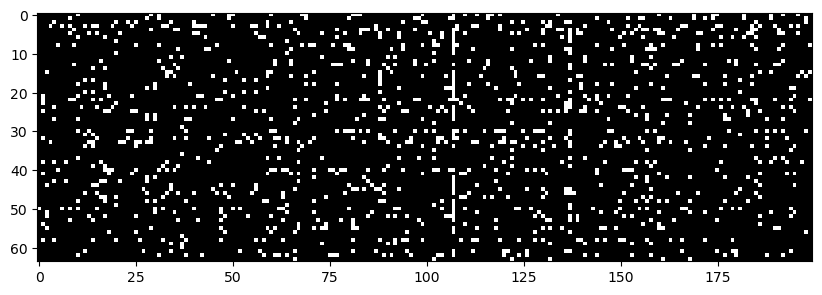

In [156]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

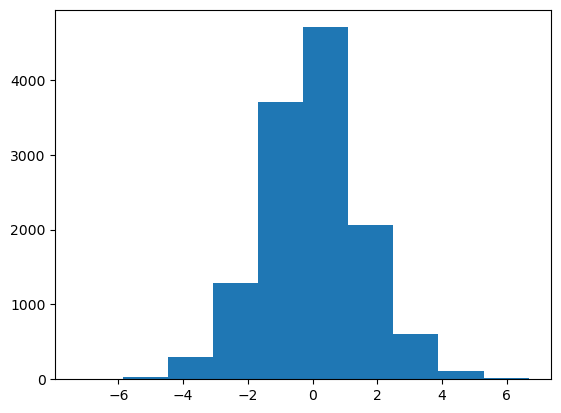

In [157]:
plt.hist(hpreact.view(-1).tolist());

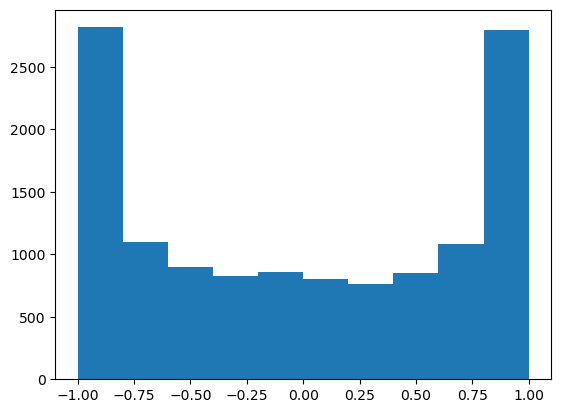

In [158]:
plt.hist(h.view(-1).tolist());

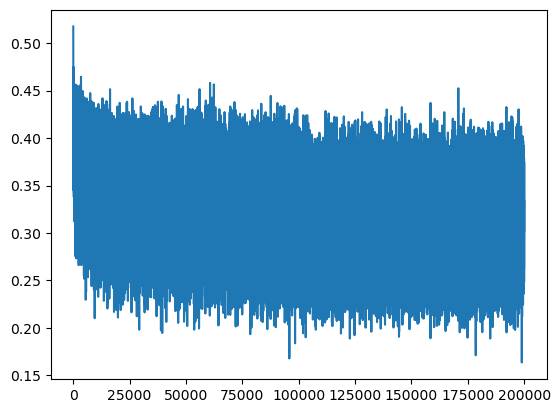

In [159]:
plt.plot(lossi)

In [160]:
# calibrate the batch norm at the end of training to be able to accept single inputs during inference as we are not passing normalised batchess during trainng
with torch.no_grad():
    #pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    #measure std deviation / mean across the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [161]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) #concat into N(total samples), block_size * n_embed
    hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
    #batch normalisation
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact) #(N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0346548557281494
dev 2.1010234355926514


In [162]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initializing with . . .
    while True:
        #forward pass
        emb = C[torch.tensor([context])] #(1, block_size, n_embed)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 #+ b1 # b1 will get by hpreact - bnmean and will have no impact. bnbias is instead there to add bias
        #batch normalisation
        hpreact = bngain * (hpreact - bnmean)/ bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        #sample from the distribtion
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        #shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        #if we encounted a special character
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word

carmah.
amillivi.
kimri.
reigh.
halaysie.
rahnel.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jord.
quintis.
lilea.
jadiquinte.
madiarinix.
kael.
druan.
edde.


tensor(0.0023) tensor(0.9922)
tensor(0.0064) tensor(1.0012)


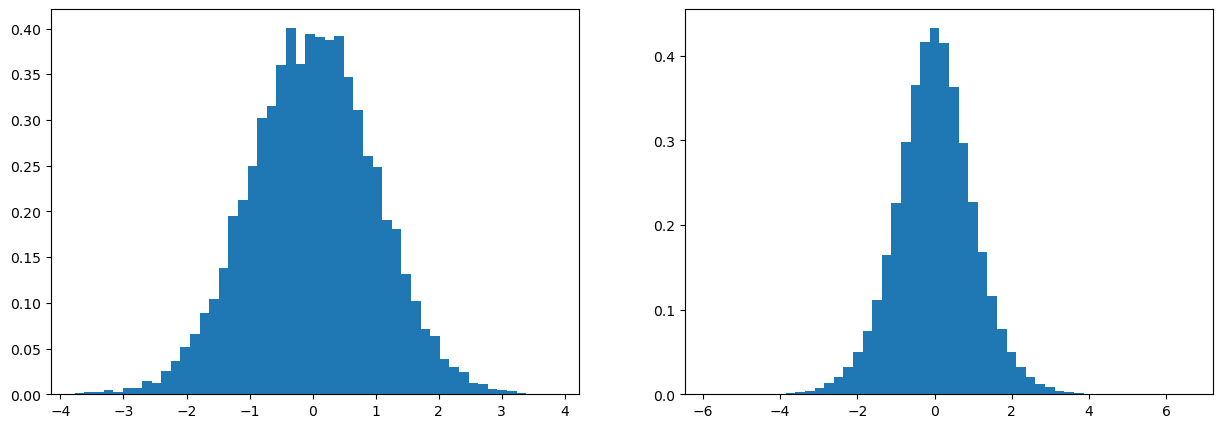

In [78]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [ ]:
# Pytorchifying the code by reimplementing liner layer, batch norm layer and tanh in pytorch nomenclature

In [208]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters - trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # bufers - not trained with backprop but on the side with momentum to counter the batch norm on single input inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+ self.eps) # normailise to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embed = 10 # the dimensionality of the embedding lookup table\
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    #last layer make less confident
    layers[-1].gamma *= 0.1
    # all othe rlayers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # just to fuck and see normalisation affect #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of params in total
for p in parameters:
    p.requires_grad = True

47551


In [214]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch contruct
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0] , -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER DEBUG - would take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break #AFTER DEBUB - would obv remove it to run full application

      0/ 200000: 2.8656
  10000/ 200000: 2.6964
  20000/ 200000: 2.1584
  30000/ 200000: 1.8965
  40000/ 200000: 1.9133
  50000/ 200000: 2.3149
  60000/ 200000: 2.1269
  70000/ 200000: 1.8842
  80000/ 200000: 2.5051
  90000/ 200000: 2.1663
 100000/ 200000: 2.0304
 110000/ 200000: 1.9515
 120000/ 200000: 2.3727
 130000/ 200000: 2.1739
 140000/ 200000: 2.1162
 150000/ 200000: 1.9481
 160000/ 200000: 2.0732
 170000/ 200000: 2.3843
 180000/ 200000: 2.2067
 190000/ 200000: 1.9456


layer 2 (      Tanh): mean -0.00, std 0.69, saturated: 15.25%
layer 5 (      Tanh): mean -0.02, std 0.73, saturated: 16.34%
layer 8 (      Tanh): mean +0.00, std 0.75, saturated: 16.03%
layer 11 (      Tanh): mean +0.00, std 0.76, saturated: 16.88%
layer 14 (      Tanh): mean -0.01, std 0.78, saturated: 18.56%


Text(0.5, 1.0, 'activation distribution')

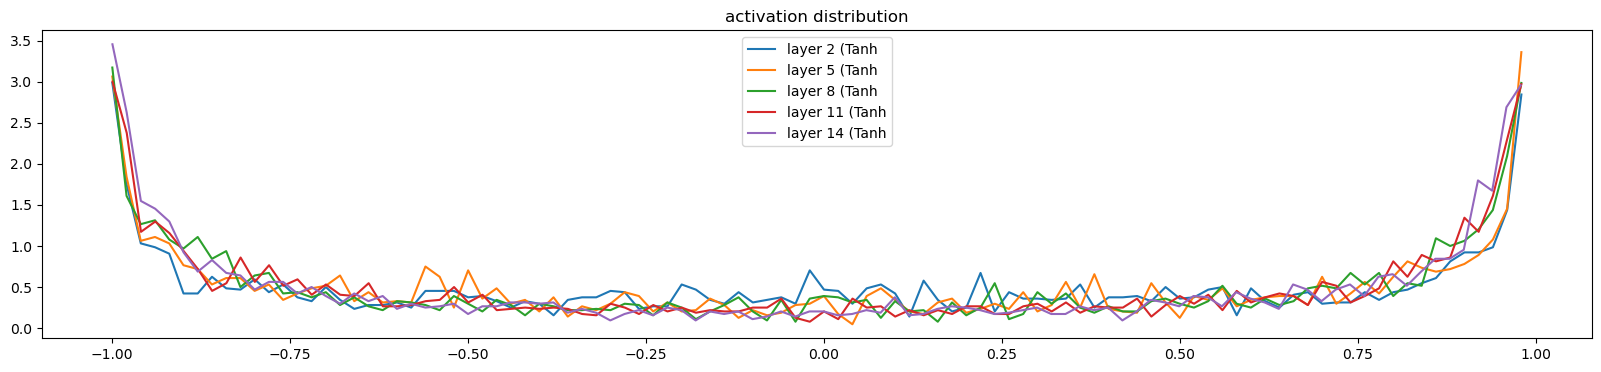

In [215]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.040780e-03
layer 5 (      Tanh): mean -0.000000, std 3.004817e-03
layer 8 (      Tanh): mean +0.000000, std 2.862270e-03
layer 11 (      Tanh): mean -0.000000, std 3.084705e-03
layer 14 (      Tanh): mean +0.000000, std 3.372164e-03


Text(0.5, 1.0, 'gradient distribution')

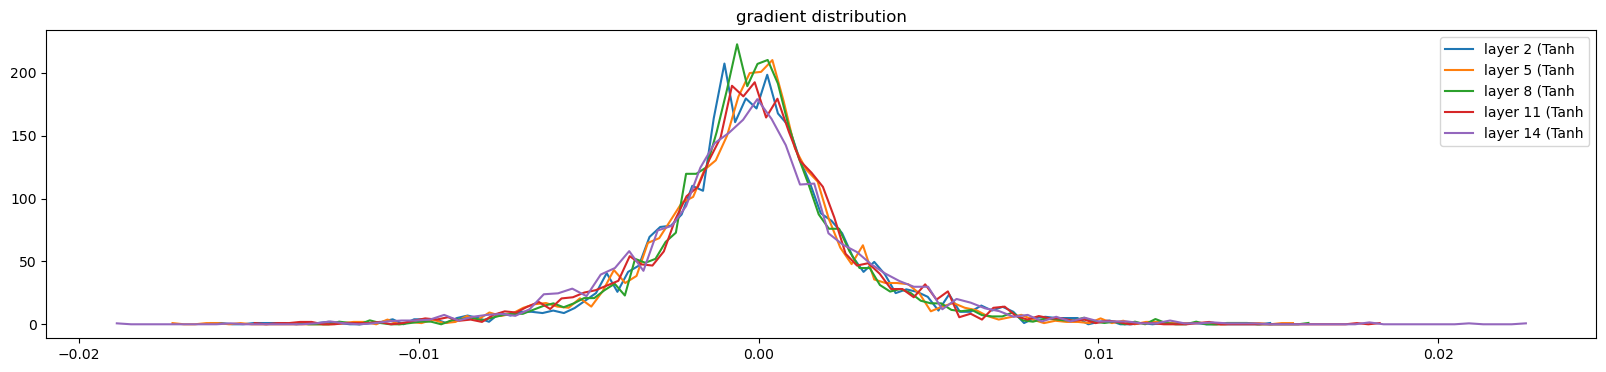

In [216]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.166056e-02 | grad:data ratio 1.068530e-02
weight  (30, 100) | mean +0.000134 | std 6.613689e-03 | grad:data ratio 1.611287e-02
weight (100, 100) | mean -0.000020 | std 4.744682e-03 | grad:data ratio 1.913645e-02
weight (100, 100) | mean -0.000048 | std 4.605998e-03 | grad:data ratio 1.884356e-02
weight (100, 100) | mean +0.000013 | std 4.373947e-03 | grad:data ratio 1.850002e-02
weight (100, 100) | mean -0.000014 | std 4.432306e-03 | grad:data ratio 1.942159e-02
weight  (100, 27) | mean +0.000080 | std 7.425603e-03 | grad:data ratio 2.276815e-02


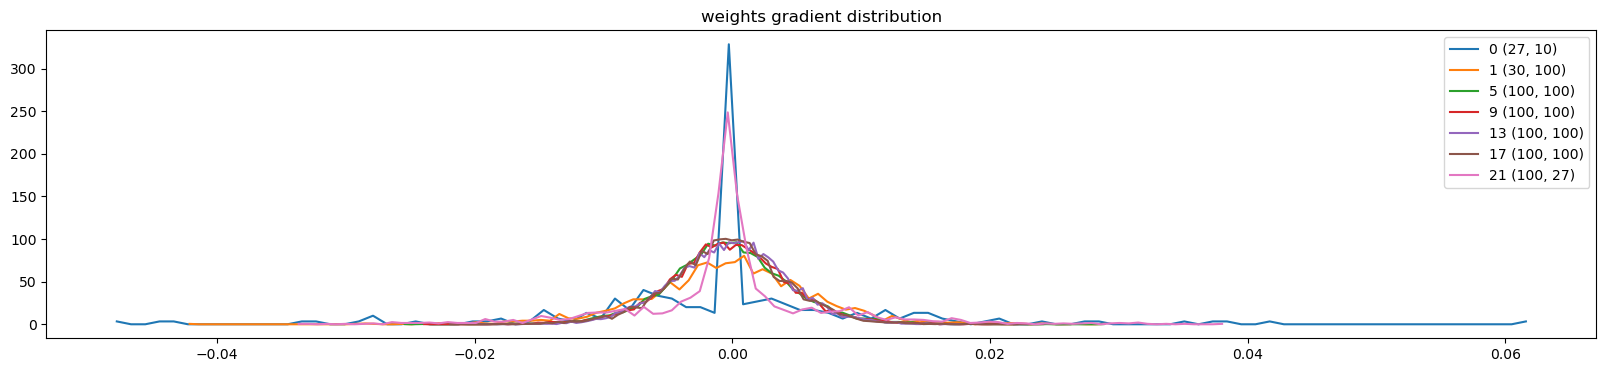

In [217]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

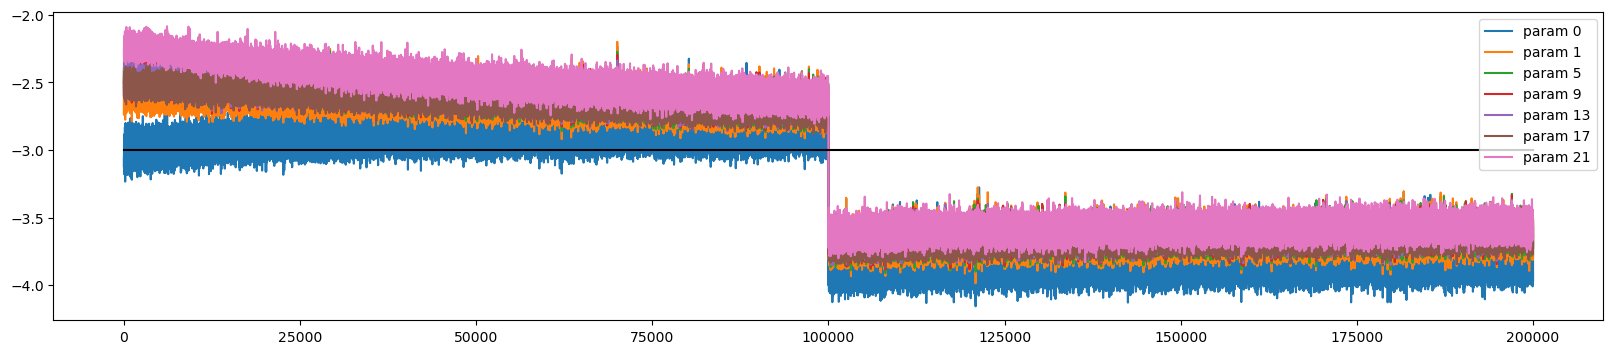

In [218]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
